# ABC Hyperparameter Optimization for SDA-U-Lite and SDA-W-Lite

This notebook performs Automated Hyperparameter Optimization using the Artificial Bee Colony (ABC) algorithm for two U-Net variant models:

- `SDA-U-Lite`
- `SDA-W-Lite`

Across the retinal vessel segmentation datasets:

- `DRIVE`, `CHASE`, `STARE`, `HRF`

Objective: Maximize validation Dice score by tuning architectural & regularization hyperparameters with a constrained evaluation budget (few epochs / limited batches per candidate) to keep search affordable.

Workflow Outline:
1. Define mixed-type hyperparameter search spaces (int, float, categorical).
2. Implement generic ABC optimizer supporting mixed representations.
3. Provide utility encoders/decoders between parameter dicts and numeric vectors.
4. Lightweight evaluation: quick training (e.g., 2 epochs; limited batches) to approximate validation Dice.
5. Run optimization per (model, dataset) pair.
6. Aggregate best hyperparameters and scores into a summary table and save to `results/hpo_results/`.
7. Visualize convergence & final comparisons.

Safety Switch: Set `RUN_OPTIMIZATION = True` to actually launch searches. Default is `False` so you can inspect code first.

Note: Full training for every candidate is computationally expensive; this uses a *proxy objective*. After selecting best hyperparameters, you should re-train the model fully (with your normal training script) for definitive performance.

---


In [1]:
!git clone https://github.com/Ismailea4/SA-U-Lite_retinal_vessel_segmentation.git

Cloning into 'SA-U-Lite_retinal_vessel_segmentation'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 185 (from 2)
Receiving objects: 100% (186/186), 319.47 MiB | 47.03 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (113/113), done.


In [2]:
%cd SA-U-Lite_retinal_vessel_segmentation

/kaggle/working/SA-U-Lite_retinal_vessel_segmentation


In [3]:
# Install the library (if not already installed)
!pip install gdown

# Download the file using the File ID
import gdown

# Replace with your actual File ID
file_id = '1r6mywExy8cp8w93ORpyyeS_rM5SDW1G9'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'downloaded_file.zip'  # Name you want to give the file in Kaggle

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1r6mywExy8cp8w93ORpyyeS_rM5SDW1G9
From (redirected): https://drive.google.com/uc?id=1r6mywExy8cp8w93ORpyyeS_rM5SDW1G9&confirm=t&uuid=5650b2c0-f148-4a79-8f52-ef3b5613c0fb
To: /kaggle/working/SA-U-Lite_retinal_vessel_segmentation/downloaded_file.zip
100%|██████████| 551M/551M [00:05<00:00, 101MB/s]  


'downloaded_file.zip'

In [4]:
!unzip downloaded_file.zip

Archive:  downloaded_file.zip
   creating: dataset/CHASE/
   creating: dataset/CHASE/test/
   creating: dataset/CHASE/test/images/
  inflating: dataset/CHASE/test/images/Image_11L.jpg  
  inflating: dataset/CHASE/test/images/Image_11R.jpg  
  inflating: dataset/CHASE/test/images/Image_12L.jpg  
  inflating: dataset/CHASE/test/images/Image_12R.jpg  
  inflating: dataset/CHASE/test/images/Image_13L.jpg  
  inflating: dataset/CHASE/test/images/Image_13R.jpg  
  inflating: dataset/CHASE/test/images/Image_14L.jpg  
  inflating: dataset/CHASE/test/images/Image_14R.jpg  
   creating: dataset/CHASE/test/labels/
  inflating: dataset/CHASE/test/labels/Image_11L_label.png  
  inflating: dataset/CHASE/test/labels/Image_11R_label.png  
  inflating: dataset/CHASE/test/labels/Image_12L_label.png  
  inflating: dataset/CHASE/test/labels/Image_12R_label.png  
  inflating: dataset/CHASE/test/labels/Image_13L_label.png  
  inflating: dataset/CHASE/test/labels/Image_13R_label.png  
 extracting: dataset/CH

In [5]:
# Imports & Basic Setup
import os
import math
import json
import time
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Project modules
import config
from data_loader import get_dataloaders
from losses import DiceBCELoss
from metrics import dice_coefficient

from models.sda_ulite import ConfigurableSDAULite
from models.sda_wlite import ConfigurableSDAWLite

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Reproducibility (can be relaxed for exploration)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

# Datasets to optimize
DATASETS = list(config.DATASETS.keys())
TARGET_MODELS = ['SDA-U-Lite', 'SDA-W-Lite']  # reference names for readability

# Directory for HPO results
HPO_RESULTS_DIR = Path('results') / 'hpo_results'
HPO_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RUN_OPTIMIZATION = True  # Set True to execute optimization loops

print(f"Datasets: {DATASETS}")
print(f"Models: {TARGET_MODELS}")

Using device: cuda
Datasets: ['CHASE', 'DRIVE', 'STARE', 'HRF']
Models: ['SDA-U-Lite', 'SDA-W-Lite']


In [6]:
# Hyperparameter Search Spaces (mixed-type)
# Each entry lists parameter metadata for encoding/decoding
# type: 'int', 'float', 'categorical'
# For floats we use (low, high); for int (low, high, step); for categorical list of choices

SEARCH_SPACES = {
    'SDA-U-Lite': [
        {'name': 'base_channels', 'type': 'int', 'low': 8, 'high': 48, 'step': 8},
        {'name': 'attention_kernel_size', 'type': 'int', 'low': 5, 'high': 9, 'step': 2},
        {'name': 'block_size', 'type': 'int', 'low': 5, 'high': 9, 'step': 2},
        {'name': 'keep_prob', 'type': 'float', 'low': 0.85, 'high': 0.98},
        {'name': 'dropout_rate', 'type': 'float', 'low': 0.0, 'high': 0.3},
        {'name': 'activation', 'type': 'categorical', 'choices': ['relu', 'gelu', 'leaky_relu']},
        {'name': 'learning_rate', 'type': 'float', 'low': 1e-4, 'high': 5e-3}
    ],
    'SDA-W-Lite': [
        {'name': 'base_channels', 'type': 'int', 'low': 16, 'high': 96, 'step': 16},
        {'name': 'attention_kernel_size', 'type': 'int', 'low': 5, 'high': 9, 'step': 2},
        {'name': 'block_size', 'type': 'int', 'low': 5, 'high': 9, 'step': 2},
        {'name': 'keep_prob', 'type': 'float', 'low': 0.85, 'high': 0.98},
        {'name': 'dropout_rate', 'type': 'float', 'low': 0.0, 'high': 0.3},
        {'name': 'activation', 'type': 'categorical', 'choices': ['relu', 'gelu', 'leaky_relu']},
        {'name': 'learning_rate', 'type': 'float', 'low': 1e-4, 'high': 5e-3}
    ]
}

# Utility: default fixed parameters that are not optimized but required by constructors
FIXED_PARAMS = {
    'SDA-U-Lite': {
        'input_channel': 3,
        'num_classes': 1
    },
    'SDA-W-Lite': {
        'input_channel': 3,
        'num_classes': 1
    }
}

print('Search space defined for models:')
for k, v in SEARCH_SPACES.items():
    print(f"  {k}: {len(v)} hyperparameters")

Search space defined for models:
  SDA-U-Lite: 7 hyperparameters
  SDA-W-Lite: 7 hyperparameters


In [7]:
# Parameter Encoding / Decoding Utilities

def sample_random(space):
    params = {}
    for spec in space:
        if spec['type'] == 'int':
            choices = list(range(spec['low'], spec['high'] + 1, spec['step']))
            params[spec['name']] = random.choice(choices)
        elif spec['type'] == 'float':
            params[spec['name']] = random.uniform(spec['low'], spec['high'])
        elif spec['type'] == 'categorical':
            params[spec['name']] = random.choice(spec['choices'])
        else:
            raise ValueError(f"Unknown type {spec['type']}")
    return params


def clamp_and_round(value, low, high):
    return max(low, min(high, value))


def dict_to_vector(params, space):
    vec = []
    for spec in space:
        v = params[spec['name']]
        if spec['type'] == 'categorical':
            idx = spec['choices'].index(v)
            vec.append(float(idx))
        elif spec['type'] == 'int':
            # Normalize to index relative to low/step
            idx = (v - spec['low']) / spec['step']
            vec.append(float(idx))
        elif spec['type'] == 'float':
            # Scale to [0,1]
            scaled = (v - spec['low']) / (spec['high'] - spec['low'])
            vec.append(float(scaled))
    return np.array(vec, dtype=np.float32)


def vector_to_dict(vec, space):
    params = {}
    for i, spec in enumerate(space):
        raw = vec[i]
        if spec['type'] == 'categorical':
            idx = int(round(clamp_and_round(raw, 0, len(spec['choices']) - 1)))
            params[spec['name']] = spec['choices'][idx]
        elif spec['type'] == 'int':
            max_idx = (spec['high'] - spec['low']) / spec['step']
            idx = int(round(clamp_and_round(raw, 0, max_idx)))
            params[spec['name']] = spec['low'] + idx * spec['step']
        elif spec['type'] == 'float':
            val = spec['low'] + clamp_and_round(raw, 0.0, 1.0) * (spec['high'] - spec['low'])
            params[spec['name']] = float(val)
    return params


def mutate_vector(vec, space, phi=None):
    # phi in [-1,1]
    if phi is None:
        phi = random.uniform(-1, 1)
    new_vec = vec.copy()
    dim = len(vec)
    idx = random.randrange(dim)
    new_vec[idx] = new_vec[idx] + phi * (new_vec[idx] - random.uniform(0, 1))
    # Clamp categorical/int indices implicitly later during decode
    return new_vec

# Quick sanity test
_test_space = SEARCH_SPACES['SDA-U-Lite']
rand_params = sample_random(_test_space)
vec = dict_to_vector(rand_params, _test_space)
back = vector_to_dict(vec, _test_space)
print('Encoding test:')
print(rand_params)
print(vec)
print(back)

Encoding test:
{'base_channels': 48, 'attention_kernel_size': 5, 'block_size': 5, 'keep_prob': 0.9464015649687783, 'dropout_rate': 0.07346755614104286, 'activation': 'relu', 'learning_rate': 0.0037087089494036605}
[5.         0.         0.         0.7415505  0.24489185 0.
 0.73647124]
{'base_channels': 48, 'attention_kernel_size': 5, 'block_size': 5, 'keep_prob': 0.9464015656709671, 'dropout_rate': 0.073467555642128, 'activation': 'relu', 'learning_rate': 0.003708709055185318}


In [8]:
class BeeColony:
    """
    Algorithme d'optimisation par colonie d'abeilles artificielles (ABC)
    Ajout de sorties console pour suivre la progression.
    """
    def __init__(self, num_bees, num_parameters, parameter_ranges, objective_function,
                 max_iterations=100, limit=20, is_minimize=True,
                 verbose=False, progress_interval=1):
        """
        Paramètres:
        - num_bees: nombre de sources de nourriture (solutions) gérées
        - num_parameters: dimension du vecteur de paramètres
        - parameter_ranges: liste de tuples (min, max) pour chaque paramètre
        - objective_function: fonction objectif à minimiser ou maximiser
        - max_iterations: nombre maximal d'itérations ABC
        - limit: nombre maximal d'essais avant qu'une source soit remplacée (scout)
        - is_minimize: True pour minimisation, False pour maximisation
        - verbose: afficher la progression si True
        - progress_interval: fréquence d'affichage (toutes les N itérations)
        """
        self.num_bees = num_bees
        self.num_parameters = num_parameters
        self.parameter_ranges = parameter_ranges
        self.objective_function = objective_function
        self.max_iterations = max_iterations
        self.limit = limit
        self.is_minimize = is_minimize
        self.verbose = verbose
        self.progress_interval = max(1, progress_interval)

        # Initialiser les sources de nourriture aléatoirement
        self.food_sources = np.zeros((num_bees, num_parameters))
        for i in range(num_bees):
            for j in range(num_parameters):
                min_val, max_val = self.parameter_ranges[j]
                self.food_sources[i, j] = min_val + np.random.random() * (max_val - min_val)

        # Évaluer chaque source de nourriture
        self.objective_values = np.zeros(num_bees)
        for i in range(num_bees):
            self.objective_values[i] = self.objective_function(self.food_sources[i])

        # Calculer la fitness pour chaque source de nourriture
        self.fitness = np.zeros(num_bees)
        for i in range(num_bees):
            self.fitness[i] = self._calculate_fitness(self.objective_values[i])

        # Compteurs d'essais
        self.trials = np.zeros(num_bees)

        # Meilleure source initiale
        best_index = np.argmax(self.fitness)
        self.best_source = np.copy(self.food_sources[best_index])
        self.best_objective = self.objective_values[best_index]

        # Historique convergence
        self.fitness_history = []

        if self.verbose:
            print(f"[INIT] Best objective = {self.best_objective:.4f}")

    def _calculate_fitness(self, objective_value):
        if self.is_minimize:
            if objective_value >= 0:
                return 1 / (1 + objective_value)
            else:
                return 1 + abs(objective_value)
        else:
            if objective_value >= 0:
                return 1 + objective_value
            else:
                return 1 / (1 + abs(objective_value))

    def _roulette_wheel_selection(self):
        sum_fitness = np.sum(self.fitness)
        if sum_fitness == 0:
            probabilities = np.ones(self.num_bees) / self.num_bees
        else:
            probabilities = self.fitness / sum_fitness
        cumsum = np.cumsum(probabilities)
        r = np.random.random()
        for i in range(self.num_bees):
            if r <= cumsum[i]:
                return i
        return np.random.randint(0, self.num_bees)  # fallback

    def _generate_new_position(self, i):
        j = np.random.randint(0, self.num_parameters)
        k = np.random.randint(0, self.num_bees)
        while k == i:
            k = np.random.randint(0, self.num_bees)
        new_position = np.copy(self.food_sources[i])
        phi = np.random.random() * 2 - 1  # [-1,1]
        new_position[j] = new_position[j] + phi * (new_position[j] - self.food_sources[k, j])
        min_val, max_val = self.parameter_ranges[j]
        new_position[j] = max(min(new_position[j], max_val), min_val)
        return new_position

    def _scout_bee_search(self):
        max_trials_index = np.argmax(self.trials)
        if self.trials[max_trials_index] >= self.limit:
            for j in range(self.num_parameters):
                min_val, max_val = self.parameter_ranges[j]
                self.food_sources[max_trials_index, j] = min_val + np.random.random() * (max_val - min_val)
            self.objective_values[max_trials_index] = self.objective_function(self.food_sources[max_trials_index])
            self.fitness[max_trials_index] = self._calculate_fitness(self.objective_values[max_trials_index])
            self.trials[max_trials_index] = 0
            if self.verbose:
                print(f"[SCOUT] Replaced source {max_trials_index}")

    def optimize(self):
        self.fitness_history = []
        start_time = time.time()
        for iteration in range(1, self.max_iterations + 1):
            # Phase ouvrières
            for i in range(self.num_bees):
                new_position = self._generate_new_position(i)
                new_objective = self.objective_function(new_position)
                new_fitness = self._calculate_fitness(new_objective)
                if new_fitness > self.fitness[i]:
                    self.food_sources[i] = new_position
                    self.objective_values[i] = new_objective
                    self.fitness[i] = new_fitness
                    self.trials[i] = 0
                else:
                    self.trials[i] += 1

            # Mettre à jour meilleure source après ouvrières
            best_index = np.argmax(self.fitness)
            if self.fitness[best_index] > self._calculate_fitness(self.best_objective):
                self.best_source = np.copy(self.food_sources[best_index])
                self.best_objective = self.objective_values[best_index]

            # Phase spectatrices
            for _ in range(self.num_bees):
                i = self._roulette_wheel_selection()
                new_position = self._generate_new_position(i)
                new_objective = self.objective_function(new_position)
                new_fitness = self._calculate_fitness(new_objective)
                if new_fitness > self.fitness[i]:
                    self.food_sources[i] = new_position
                    self.objective_values[i] = new_objective
                    self.fitness[i] = new_fitness
                    self.trials[i] = 0
                else:
                    self.trials[i] += 1

            # Phase éclaireuses
            self._scout_bee_search()

            # Mettre à jour meilleure source globale
            best_index = np.argmax(self.fitness)
            if self.fitness[best_index] > self._calculate_fitness(self.best_objective):
                self.best_source = np.copy(self.food_sources[best_index])
                self.best_objective = self.objective_values[best_index]

            # Historique
            self.fitness_history.append(self.best_objective)

            if self.verbose and (iteration % self.progress_interval == 0 or iteration == 1 or iteration == self.max_iterations):
                elapsed = time.time() - start_time
                print(f"[ITER {iteration:03d}/{self.max_iterations}] best={self.best_objective:.4f} elapsed={elapsed:.1f}s")

        return self.best_source, self.best_objective

In [16]:
# Evaluation Function (proxy training) - FIXED to use dataset config
# To keep search affordable: small epochs, limited batches

def build_model(model_name, params):
    if model_name == 'SDA-U-Lite':
        return ConfigurableSDAULite(
            input_channel=FIXED_PARAMS[model_name]['input_channel'],
            num_classes=FIXED_PARAMS[model_name]['num_classes'],
            base_channels=params['base_channels'],
            attention_kernel_size=params['attention_kernel_size'],
            block_size=params['block_size'],
            keep_prob=params['keep_prob'],
            activation=params['activation'],
            dropout_rate=params['dropout_rate']
        )
    elif model_name == 'SDA-W-Lite':
        return ConfigurableSDAWLite(
            input_channel=FIXED_PARAMS[model_name]['input_channel'],
            num_classes=FIXED_PARAMS[model_name]['num_classes'],
            base_channels=params['base_channels'],
            attention_kernel_size=params['attention_kernel_size'],
            block_size=params['block_size'],
            keep_prob=params['keep_prob'],
            activation=params['activation'],
            dropout_rate=params['dropout_rate']
        )
    else:
        raise ValueError(f"Unknown model {model_name}")


def subset_loader(loader, max_batches=4):
    batches = []
    for i, batch in enumerate(loader):
        batches.append(batch)
        if i + 1 >= max_batches:
            break
    return batches


def evaluate_params(model_name, dataset_name, params, epochs=10, max_batches=4, debug=False,
                    early_stop_patience=3, early_stop_min_delta=1e-3):
    # Use proper dataset configuration
    dataset_config = config.DATASETS[dataset_name]
    train_loader, val_loader, _ = get_dataloaders(dataset_config, batch_size=4)
    train_batches = subset_loader(train_loader, max_batches=max_batches)
    val_batches = subset_loader(val_loader, max_batches=max_batches)

    if debug:
        print(f"Eval debug: dataset={dataset_name} model={model_name} train_batches={len(train_batches)} val_batches={len(val_batches)}")

    if len(val_batches) == 0 or len(train_batches) == 0:
        if debug:
            print("No batches available; returning 0.0")
        return 0.0

    model = build_model(model_name, params).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = DiceBCELoss()

    best_val = -float('inf')
    patience_left = early_stop_patience

    for ep in range(1, epochs + 1):
        model.train()
        for (images, masks) in train_batches:
            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        dices = []
        with torch.no_grad():
            for (images, masks) in val_batches:
                images = images.to(DEVICE, dtype=torch.float32)
                masks = masks.to(DEVICE, dtype=torch.float32)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)
                dice = dice_coefficient(outputs, masks).item()
                dices.append(dice)
        mean_dice = float(np.mean(dices)) if dices else 0.0

        if debug:
            print(f"[EVAL] epoch={ep} mean_dice={mean_dice:.4f} best={best_val:.4f} patience_left={patience_left}")

        # Early stopping check
        if mean_dice > best_val + early_stop_min_delta:
            best_val = mean_dice
            patience_left = early_stop_patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                if debug:
                    print(f"[EARLY-STOP] Stop at epoch {ep} with best_dice={best_val:.4f}")
                break

    return best_val

print('Evaluation function updated with early stopping.')

Evaluation function updated with early stopping.


In [17]:
# BeeColony Parameter Mapping Helpers (moved earlier for dependency)

def build_parameter_ranges(space):
    """Return list of (min,max) for BeeColony numeric representation."""
    ranges = []
    for spec in space:
        if spec['type'] == 'categorical':
            ranges.append((0, len(spec['choices']) - 1))
        elif spec['type'] == 'int':
            num_choices = ((spec['high'] - spec['low']) // spec['step']) + 1
            ranges.append((0, num_choices - 1))
        elif spec['type'] == 'float':
            ranges.append((spec['low'], spec['high']))
        else:
            raise ValueError(f"Unknown spec type {spec['type']}")
    return ranges


def decode_vector(vec, space):
    """Convert numeric vector from BeeColony into parameter dict."""
    params = {}
    for v, spec in zip(vec, space):
        if spec['type'] == 'categorical':
            idx = int(round(max(0, min(len(spec['choices']) - 1, v))))
            params[spec['name']] = spec['choices'][idx]
        elif spec['type'] == 'int':
            num_choices = ((spec['high'] - spec['low']) // spec['step']) + 1
            idx = int(round(max(0, min(num_choices - 1, v))))
            params[spec['name']] = spec['low'] + idx * spec['step']
        elif spec['type'] == 'float':
            low, high = spec['low'], spec['high']
            val = max(low, min(high, v))
            params[spec['name']] = float(val)
    return params

print('BeeColony helpers ready (pre-optimization).')

BeeColony helpers ready (pre-optimization).


In [18]:
# Run Optimization for each (model, dataset) using BeeColony
# Stores best results and convergence history with verbose progress

OPT_RESULTS = []  # list of dicts
CONVERGENCE = {}  # (model,dataset) -> fitness_history list

BEE_CONFIG = {
    'num_bees': 10,          # reduce a bit for speed
    'limit': 3,
    'max_iterations': 10,
    'is_minimize': False,
    'progress_interval': 1,
    'verbose': True
}

if RUN_OPTIMIZATION:
    start_global = time.time()
    for dataset_name in DATASETS:
        print(f"\n=== Dataset: {dataset_name} ===")
        for model_name in TARGET_MODELS:
            print(f"\n>> Optimizing {model_name} ...")
            space = SEARCH_SPACES[model_name]
            param_ranges = build_parameter_ranges(space)
            num_parameters = len(param_ranges)

            eval_counter = {'calls': 0}

            def objective(vector):
                param_dict = decode_vector(vector, space)
                print(f"[EVAL] call={eval_counter['calls']+1} model={model_name} dataset={dataset_name} params={param_dict}")
                try:
                    score = evaluate_params(
                        model_name, dataset_name, param_dict,
                        epochs=20,              # more epochs
                        max_batches=6,          # small subset to limit compute
                        debug=False,            # set True to see per-epoch logs
                        early_stop_patience=3,  # early stopping
                        early_stop_min_delta=1e-3
                    )
                    print(f"[EVAL-RESULT] call={eval_counter['calls']+1} score={score:.4f}")
                except Exception as e:
                    print(f"Error during evaluation: {e}")
                    score = 0.0
                eval_counter['calls'] += 1
                return score

            colony = BeeColony(
                num_bees=BEE_CONFIG['num_bees'],
                num_parameters=num_parameters,
                parameter_ranges=param_ranges,
                objective_function=objective,
                max_iterations=BEE_CONFIG['max_iterations'],
                limit=BEE_CONFIG['limit'],
                is_minimize=BEE_CONFIG['is_minimize'],
                verbose=BEE_CONFIG['verbose'],
                progress_interval=BEE_CONFIG['progress_interval']
            )

            model_start = time.time()
            best_source, best_objective = colony.optimize()
            model_elapsed = time.time() - model_start

            fitness_history = colony.fitness_history
            CONVERGENCE[(model_name, dataset_name)] = fitness_history

            best_params = decode_vector(best_source, space)
            record = {
                'model': model_name,
                'dataset': dataset_name,
                'best_score': best_objective,
                'eval_calls': eval_counter['calls'],
                'time_sec': round(model_elapsed, 2),
                **best_params
            }
            OPT_RESULTS.append(record)
            print(f"[RESULT] {model_name} on {dataset_name}: best Dice={best_objective:.4f} time={model_elapsed:.1f}s evals={eval_counter['calls']}")
    total_time = time.time() - start_global
    print(f"\nTotal optimization time: {total_time/60:.2f} min for {len(TARGET_MODELS)*len(DATASETS)} tasks")
else:
    print("RUN_OPTIMIZATION is False. Set to True and re-run this cell to execute searches.")

print(f"Collected {len(OPT_RESULTS)} optimization records so far.")


=== Dataset: CHASE ===

>> Optimizing SDA-U-Lite ...
[EVAL] call=1 model=SDA-U-Lite dataset=CHASE params={'base_channels': 24, 'attention_kernel_size': 9, 'block_size': 7, 'keep_prob': 0.8844795743992208, 'dropout_rate': 0.038814279320262365, 'activation': 'gelu', 'learning_rate': 0.0008530041004467413}
[EVAL-RESULT] call=1 score=0.2020
[EVAL] call=2 model=SDA-U-Lite dataset=CHASE params={'base_channels': 32, 'attention_kernel_size': 5, 'block_size': 7, 'keep_prob': 0.9574150010927014, 'dropout_rate': 0.01275739005572779, 'activation': 'gelu', 'learning_rate': 0.0023591399393722936}
[EVAL-RESULT] call=2 score=0.0425
[EVAL] call=3 model=SDA-U-Lite dataset=CHASE params={'base_channels': 40, 'attention_kernel_size': 7, 'block_size': 7, 'keep_prob': 0.9528565529664492, 'dropout_rate': 0.1679275478787872, 'activation': 'gelu', 'learning_rate': 0.0005206271603408532}
[EVAL-RESULT] call=3 score=0.1308
[EVAL] call=4 model=SDA-U-Lite dataset=CHASE params={'base_channels': 40, 'attention_kernel

In [19]:
# Aggregate & Save Optimization Results

if OPT_RESULTS:
    df_results = pd.DataFrame(OPT_RESULTS)
    df_results_sorted = df_results.sort_values(['dataset', 'model'])
    display(df_results_sorted)

    # Save CSV & JSON
    csv_path = HPO_RESULTS_DIR / 'abc_hpo_results.csv'
    json_path = HPO_RESULTS_DIR / 'abc_hpo_results.json'
    df_results_sorted.to_csv(csv_path, index=False)
    with open(json_path, 'w') as f:
        json.dump(df_results_sorted.to_dict(orient='records'), f, indent=2)
    print(f"Saved results to {csv_path} and {json_path}")
else:
    print("No optimization results yet (RUN_OPTIMIZATION was False or search not run).")

,model,dataset,best_score,eval_calls,time_sec,base_channels,attention_kernel_size,block_size,keep_prob,dropout_rate,activation,learning_rate
0,SDA-U-Lite,CHASE,0.704339,219,1050.53,48,7,5,0.953112,0.180137,relu,0.004739
1,SDA-W-Lite,CHASE,0.715365,220,4160.99,48,5,9,0.967566,0.000000,relu,0.004238
2,SDA-U-Lite,DRIVE,0.733462,220,944.38,32,7,7,0.946542,0.074191,relu,0.004766
3,SDA-W-Lite,DRIVE,0.735621,219,2955.76,96,7,7,0.951094,0.147825,leaky_relu,0.001797
6,SDA-U-Lite,HRF,0.189430,219,1775.19,16,9,9,0.980000,0.064212,gelu,0.000559
7,SDA-W-Lite,HRF,0.744722,220,3326.73,80,7,9,0.978027,0.129225,relu,0.002823
4,SDA-U-Lite,STARE,0.737807,219,1018.88,48,5,7,0.889141,0.041362,gelu,0.002890
5,SDA-W-Lite,STARE,0.745068,219,4112.32,96,9,9,0.920417,0.098183,gelu,0.002251


Saved results to results/hpo_results/abc_hpo_results.csv and results/hpo_results/abc_hpo_results.json


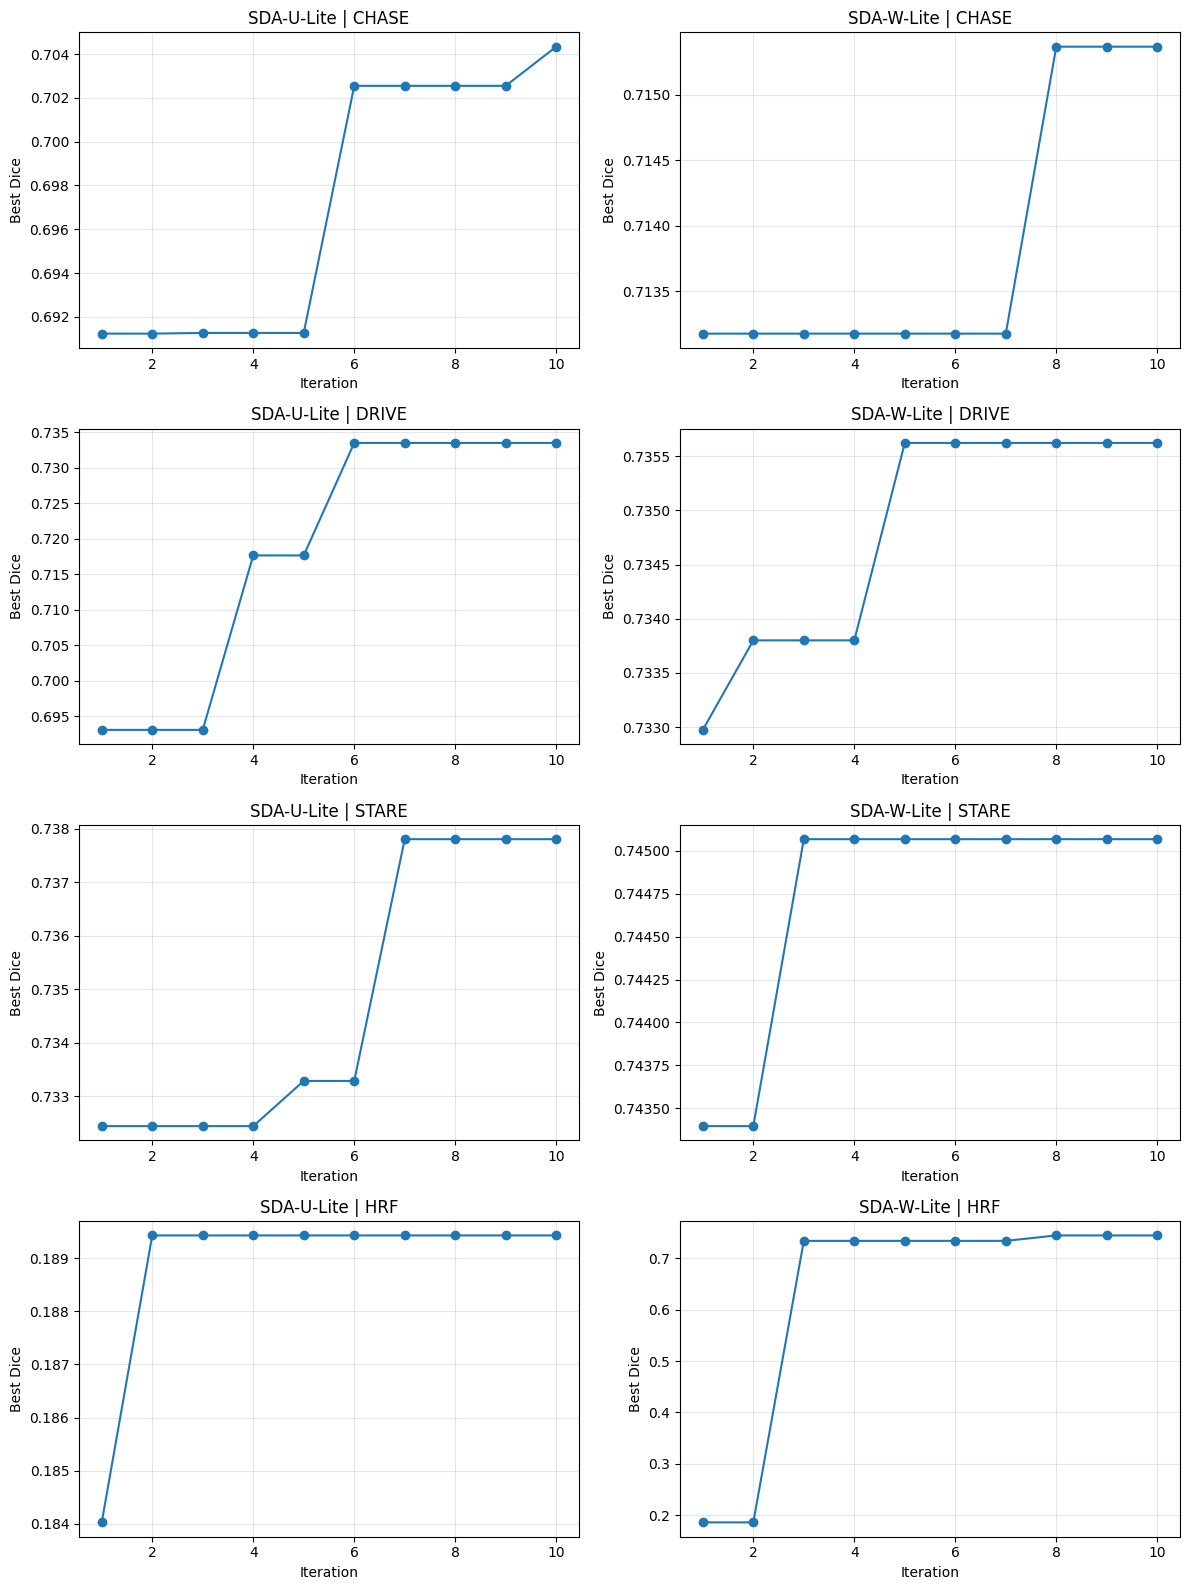

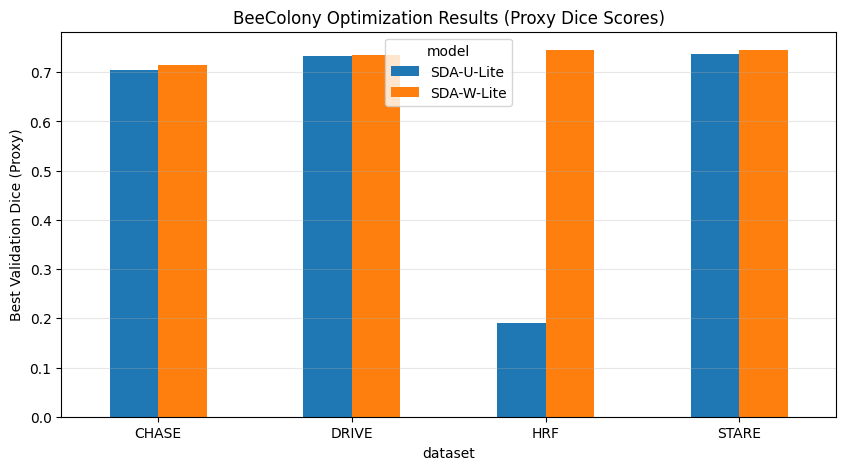

In [20]:
# Visualization: Convergence & Best Scores (BeeColony)
import matplotlib.pyplot as plt

if CONVERGENCE:
    n = len(CONVERGENCE)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    axes = axes.flatten()
    for idx, ((model_name, dataset_name), history) in enumerate(CONVERGENCE.items()):
        iters = list(range(1, len(history) + 1))
        scores = history
        ax = axes[idx]
        ax.plot(iters, scores, marker='o')
        ax.set_title(f"{model_name} | {dataset_name}")
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Best Dice')
        ax.grid(alpha=0.3)
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No convergence history to plot (optimization not run).')

if OPT_RESULTS:
    df_plot = pd.DataFrame(OPT_RESULTS)
    pivot = df_plot.pivot(index='dataset', columns='model', values='best_score')
    pivot.plot(kind='bar', figsize=(10,5))
    plt.ylabel('Best Validation Dice (Proxy)')
    plt.title('BeeColony Optimization Results (Proxy Dice Scores)')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.show()
else:
    print('No optimization results for bar chart.')

# Usage Instructions & Tips

## Running the Optimization
1. Set `RUN_OPTIMIZATION = True` in the imports/setup cell.
2. Optionally adjust `ABC_CONFIG` (increase `max_iters`, `colony_size` for deeper search).
3. Re-run the optimization loop cell.
4. Run aggregation & visualization cells to see results.

## Increasing Fidelity
- Increase `epochs` and `max_batches` inside `evaluate_params()` for a more reliable Dice estimate.
- After selecting best hyperparameters, run a full training using your main benchmarking script (`run_benchmark.py`).

## Adding More Models
- Extend `TARGET_MODELS` list.
- Add a corresponding search space in `SEARCH_SPACES`.
- Extend `build_model()` to construct the new model with given params.

## Interpreting Results
- Stored proxy scores approximate validation Dice under a *restricted* budget.
- Convergence plots show how best fitness improves over ABC iterations.
- Final CSV/JSON saved under `results/hpo_results/` for record and reproducibility.

## Caveats
- Proxy evaluation is noisy; different seeds may yield different best params.
- Categorical activations may interact with dropout and attention differently; verify stability.
- Large models may require GPU memory adjustments (reduce batch size if OOM).

---
Ready to optimize! 🚀
